# Chapter 4. Geocentric Models

In [191]:
import os
import warnings

import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.interpolate import BSpline
from scipy.stats import gaussian_kde

import jax.numpy as jnp
from jax import random, vmap

import numpyro
import numpyro.distributions as dist
import numpyro.optim as optim
from numpyro.diagnostics import hpdi, print_summary
from numpyro.infer import Predictive, SVI, Trace_ELBO, init_to_value
from numpyro.infer.autoguide import AutoLaplaceApproximation

if "SVG" in os.environ:
    %config InlineBackend.figure_formats = ["svg"]
warnings.formatwarning = lambda message, category, *args, **kwargs: "{}: {}\n".format(
    category.__name__, message
)
az.style.use("arviz-darkgrid")
numpyro.set_platform("cpu")

### Code 4.1
Distribution of the sum of 16 random movements between -1 and 1 for 1000 simulations.

(array([  3.,  33.,  68., 121., 215., 243., 160., 109.,  41.,   7.]),
 array([-7.24125147, -5.87484932, -4.50844669, -3.14204454, -1.77564228,
        -0.40924001,  0.95716226,  2.32356453,  3.68996692,  5.0563693 ,
         6.42277145]),
 <BarContainer object of 10 artists>)

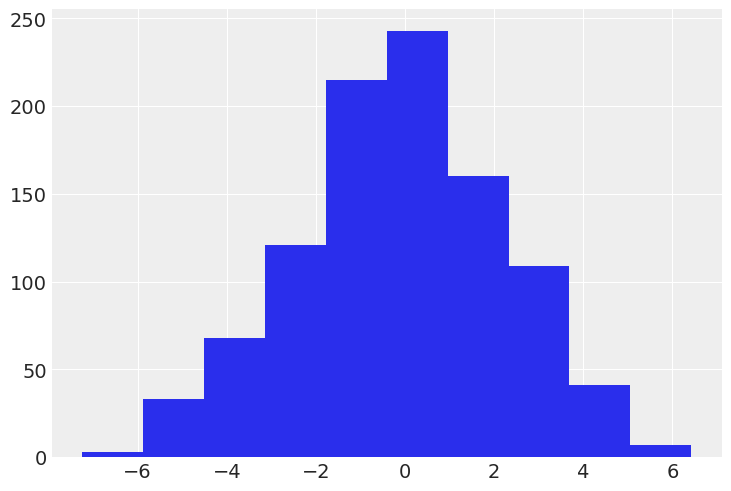

In [192]:
pos = jnp.sum(dist.Uniform(-1, 1).sample(random.PRNGKey(0), (1000, 16)), -1)
plt.hist(pos)

### Code 4.2
Sample a random growth rate.

In [193]:
jnp.prod(1 + dist.Uniform(0, 0.1).sample(random.PRNGKey(0), (12,)))

DeviceArray(1.7294353, dtype=float32)

### Code 4.3
Explore the distribution of 1000 random growth rate products and see convergence to a normal distribution.

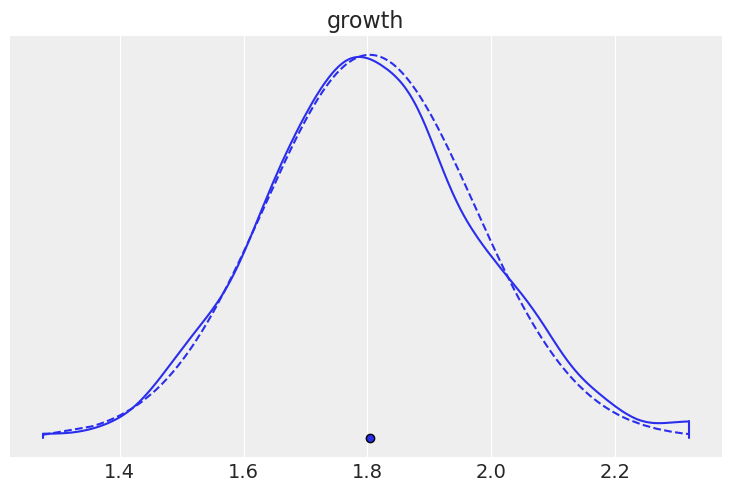

In [194]:
growth = jnp.prod(1 + dist.Uniform(0, 0.1).sample(random.PRNGKey(0), (1000, 12)), -1)
az.plot_density({"growth": growth}, hdi_prob=1)
x = jnp.sort(growth)
plt.plot(x, jnp.exp(dist.Normal(jnp.mean(x), jnp.std(x)).log_prob(x)), "--")
plt.show()

### Code 4.4
Compare the distributions of products with big and small growth rates.

<Axes: title={'center': 'small'}>

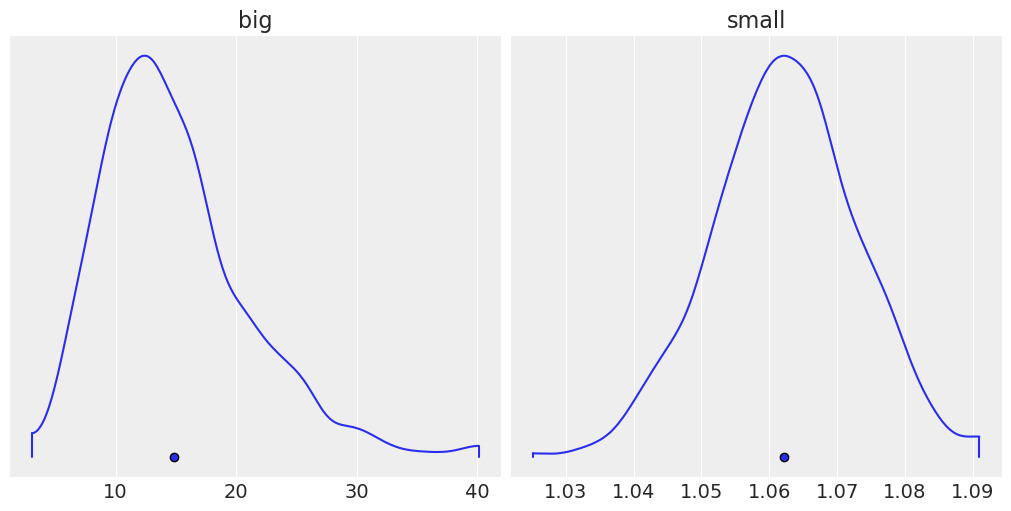

In [195]:
big = jnp.prod(1 + dist.Uniform(0, 0.5).sample(random.PRNGKey(0), (1000, 12)), -1)
small = jnp.prod(1 + dist.Uniform(0, 0.01).sample(random.PRNGKey(0), (1000, 12)), -1)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
az.plot_density({"big": big}, hdi_prob=1, ax=ax[0])
az.plot_density({"small": small}, hdi_prob=1, ax=ax[1])


### Code 4.5
Large deviates that are multplied produce Gaussian distributions on the log scale.

array([[<Axes: title={'center': 'log_big'}>]], dtype=object)

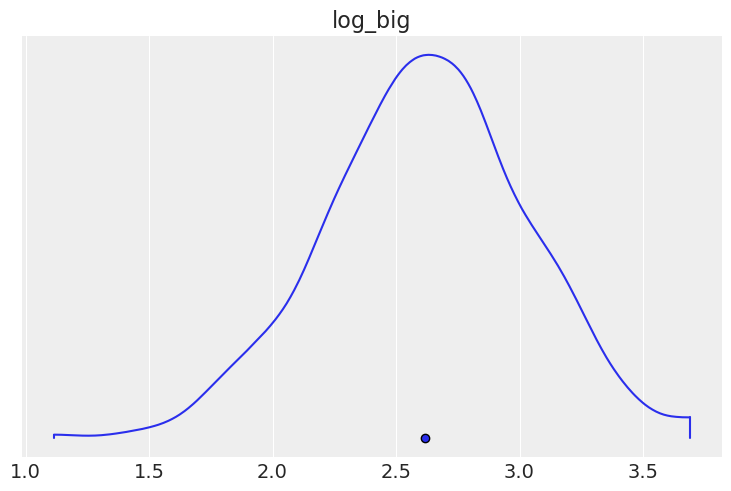

In [196]:
log_big = jnp.log(
    jnp.prod(1 + dist.Uniform(0, 0.5).sample(random.PRNGKey(0), (1000, 12)), -1)
)
az.plot_density({"log_big": log_big}, hdi_prob=1)


### Code 4.6
Bayes theorem formulation.

In [197]:
w = 6
n = 9
p_grid = jnp.linspace(start=0, stop=1, num=100)
prob_binom = jnp.exp(dist.Binomial(n, p_grid).log_prob(w))
posterior = prob_binom * jnp.exp(dist.Uniform(0, 1).log_prob(p_grid))
posterior = posterior / jnp.sum(posterior)

### Code 4.7
Import partial census data.

In [198]:
Howell1 = pd.read_csv("../data/Howell1.csv", sep=";")
d = Howell1

### Code 4.8
Explore data.

In [199]:
d.info()
d.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 544 entries, 0 to 543
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   height  544 non-null    float64
 1   weight  544 non-null    float64
 2   age     544 non-null    float64
 3   male    544 non-null    int64  
dtypes: float64(3), int64(1)
memory usage: 17.1 KB


,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


### Code 4.9
See a summary of the data with 89% intervals.

In [200]:
print_summary(dict(zip(d.columns, d.T.values)), 0.89, False)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
       age     29.34     20.75     27.00      0.00     57.00    186.38      1.03
    height    138.26     27.60    148.59     90.81    170.18    218.68      1.06
      male      0.47      0.50      0.00      0.00      1.00    670.75      1.00
    weight     35.61     14.72     40.06     11.37     55.71    305.62      1.05



### Code 4.10
Access the vector of heights.

In [201]:
d.height

0      151.765
1      139.700
2      136.525
3      156.845
4      145.415
        ...   
539    145.415
540    162.560
541    156.210
542     71.120
543    158.750
Name: height, Length: 544, dtype: float64

### Code 4.11
Limit the data frame to those who are 18 or over.

In [202]:
d2 = d[d.age >= 18]

### Code 4.12
Plot the prior for mu.

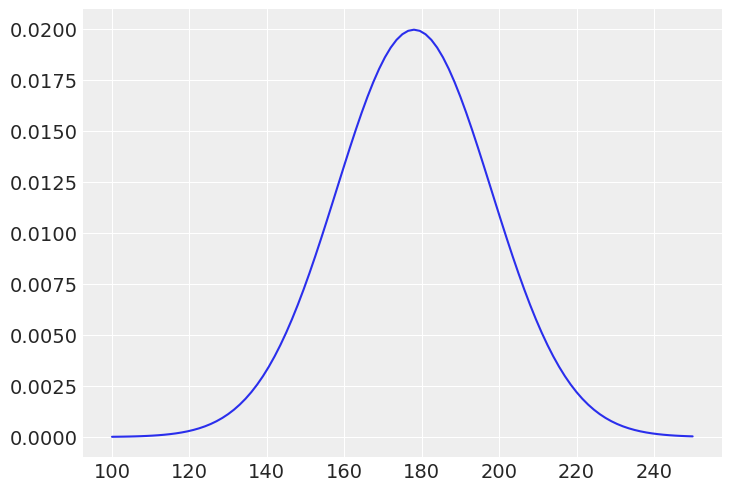

In [203]:
x = jnp.linspace(100, 250, 101)
plt.plot(x, jnp.exp(dist.Normal(178, 20).log_prob(x)))
plt.show()

### Code 4.13
Plot the prior for sigma.

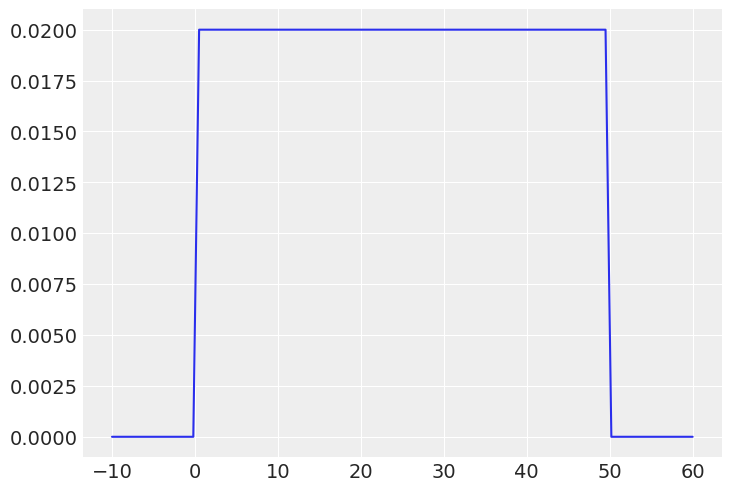

In [204]:
x = jnp.linspace(-10, 60, 101)
plt.plot(x, jnp.exp(dist.Uniform(0, 50, validate_args=True).log_prob(x)))
plt.show()

### Code 4.14
Plot simulated heights by sampling from the prior.

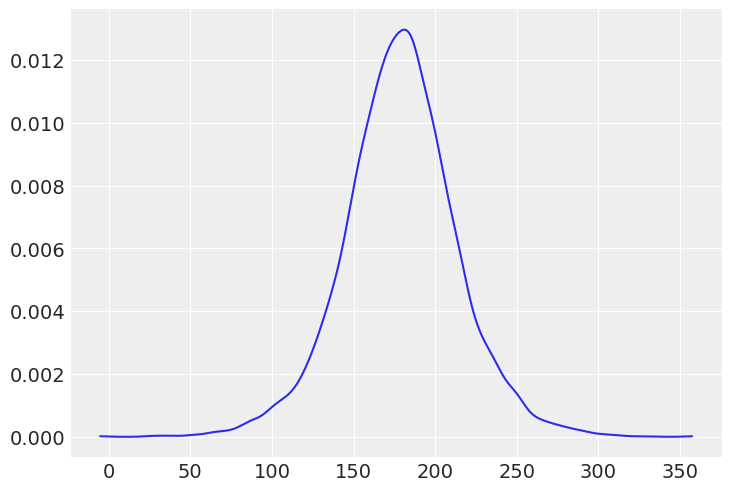

In [205]:
sample_mu = dist.Normal(178, 20).sample(random.PRNGKey(0), (int(1e4),))
sample_sigma = dist.Uniform(0, 50).sample(random.PRNGKey(1), (int(1e4),))
prior_h = dist.Normal(sample_mu, sample_sigma).sample(random.PRNGKey(2))
az.plot_kde(prior_h)
plt.show()

### Code 4.15
Adjust the prior for mu and plot simulated prior heights again.

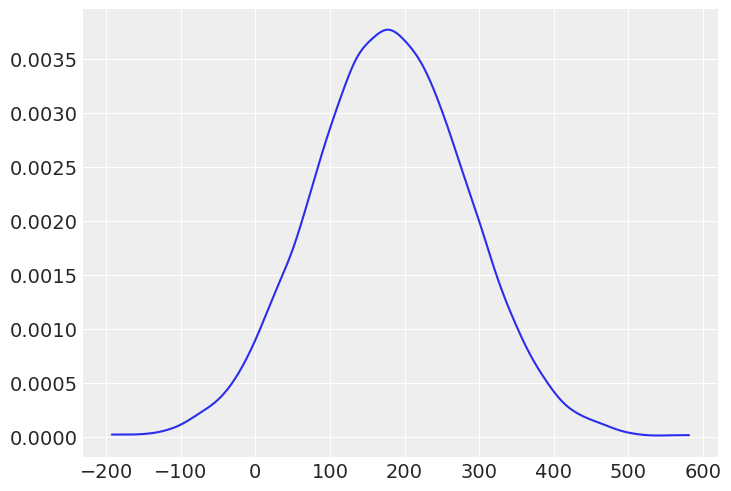

In [206]:
sample_mu = dist.Normal(178, 100).sample(random.PRNGKey(0), (int(1e4),))
prior_h = dist.Normal(sample_mu, sample_sigma).sample(random.PRNGKey(2))
az.plot_kde(prior_h)
plt.show()

### Code 4.16
Grid approximation for the posterior distribution.

In [207]:
mu_list = jnp.linspace(start=150, stop=160, num=100)
sigma_list = jnp.linspace(start=7, stop=9, num=100)
mesh = jnp.meshgrid(mu_list, sigma_list)
post = {"mu": mesh[0].reshape(-1), "sigma": mesh[1].reshape(-1)}
post["LL"] = vmap(
    lambda mu, sigma: jnp.sum(dist.Normal(mu, sigma).log_prob(d2.height.values))
)(post["mu"], post["sigma"])
logprob_mu = dist.Normal(178, 20).log_prob(post["mu"])
logprob_sigma = dist.Uniform(0, 50).log_prob(post["sigma"])
post["prob"] = post["LL"] + logprob_mu + logprob_sigma
post["prob"] = jnp.exp(post["prob"] - jnp.max(post["prob"]))

### Code 4.17
Inspect posterior with contour plots.

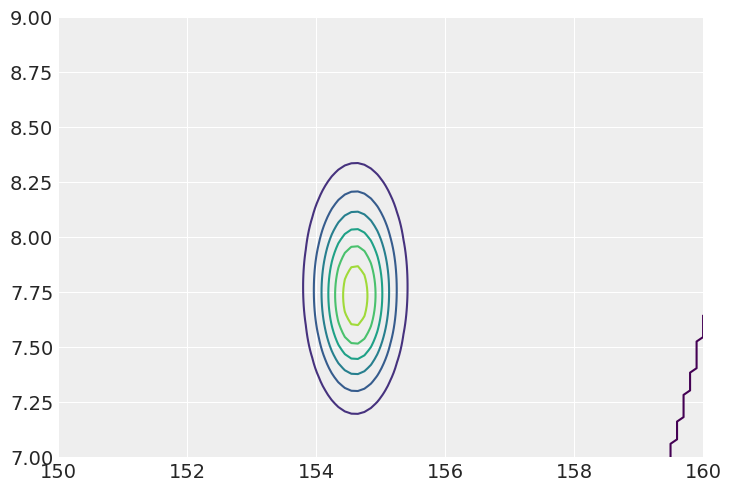

In [208]:
plt.contour(
    post["mu"].reshape(100, 100),
    post["sigma"].reshape(100, 100),
    post["prob"].reshape(100, 100),
)
plt.show()

### Code 4.18
Inspect posterior with heatmap.

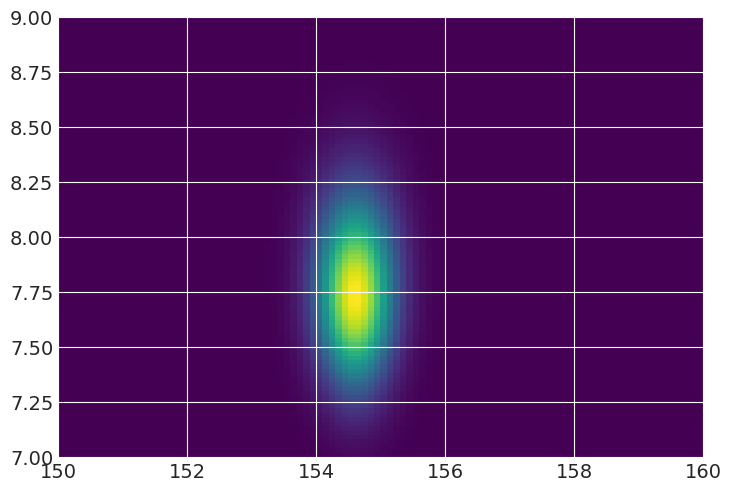

In [209]:
plt.imshow(
    post["prob"].reshape(100, 100),
    origin="lower",
    extent=(150, 160, 7, 9),
    aspect="auto",
)
plt.show()

### Code 4.19

In [210]:
prob = post["prob"] / jnp.sum(post["prob"])
sample_rows = dist.Categorical(probs=prob).sample(random.PRNGKey(0), (int(1e4),))
sample_mu = post["mu"][sample_rows]
sample_sigma = post["sigma"][sample_rows]

### Code 4.20
Take 10,000 samples (with replacement) from the posterior for the height data. These are pairs of means and standard deviations.

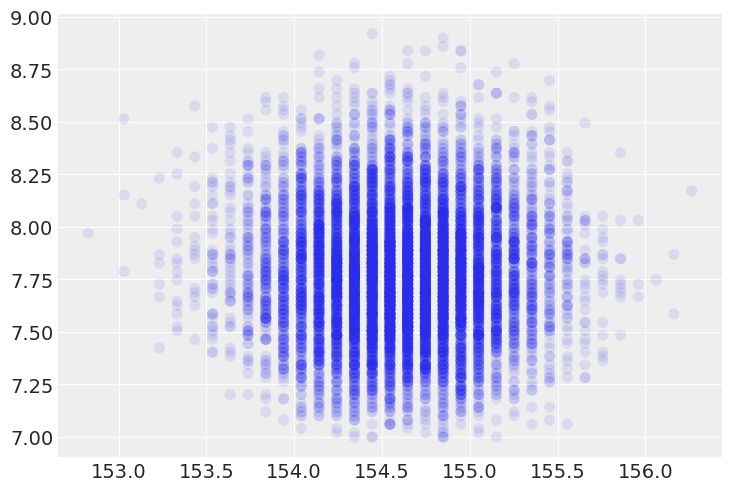

In [211]:
plt.scatter(sample_mu, sample_sigma, s=64, alpha=0.1, edgecolor="none")
plt.show()

### Code 4.21
Characterise the shapes of the marginal posterior densities.

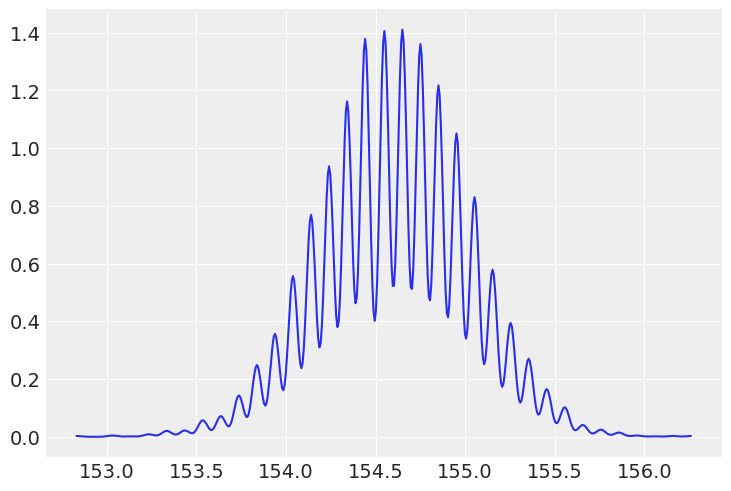

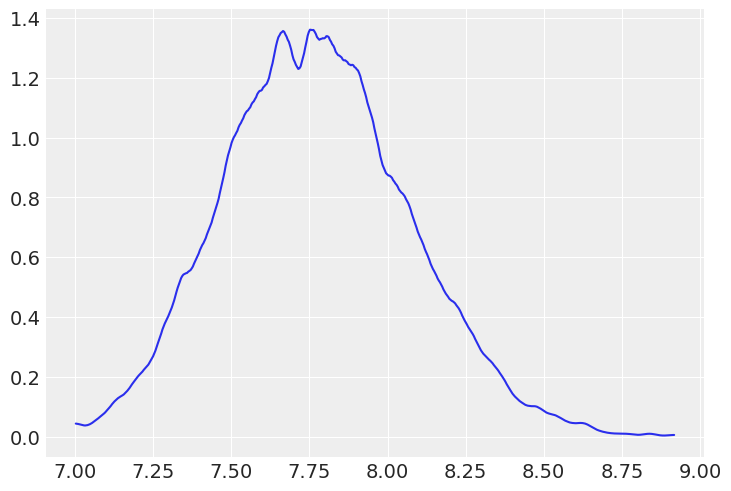

In [212]:
az.plot_kde(sample_mu)
plt.show()
az.plot_kde(sample_sigma)
plt.show()

### Code 4.22
Posterior compatibility intervals.

In [213]:
print(hpdi(sample_mu, 0.89))
print(hpdi(sample_sigma, 0.89))

[153.93939 155.15152]
[7.3232327 8.252525 ]


### Code 4.23
Sample 20 random heights from the height data.

In [214]:
d3 = d2.height.sample(n=20)

### Code 4.24
Recalculate the posterior distribution using only 20 data points, and see that we have a longer tail.

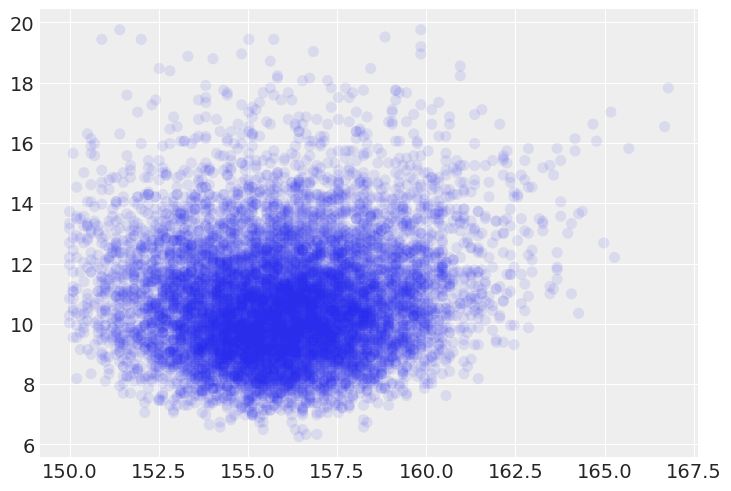

In [215]:
mu_list = jnp.linspace(start=150, stop=170, num=200)
sigma_list = jnp.linspace(start=4, stop=20, num=200)
mesh = jnp.meshgrid(mu_list, sigma_list)
post2 = {"mu": mesh[0].reshape(-1), "sigma": mesh[1].reshape(-1)}
post2["LL"] = vmap(
    lambda mu, sigma: jnp.sum(dist.Normal(mu, sigma).log_prob(d3.values))
)(post2["mu"], post2["sigma"])
logprob_mu = dist.Normal(178, 20).log_prob(post2["mu"])
logprob_sigma = dist.Uniform(0, 50).log_prob(post2["sigma"])
post2["prob"] = post2["LL"] + logprob_mu + logprob_sigma
post2["prob"] = jnp.exp(post2["prob"] - jnp.max(post2["prob"]))
prob = post2["prob"] / jnp.sum(post2["prob"])
sample2_rows = dist.Categorical(probs=prob).sample(random.PRNGKey(0), (int(1e4),))
sample2_mu = post2["mu"][sample2_rows]
sample2_sigma = post2["sigma"][sample2_rows]
plt.scatter(sample2_mu, sample2_sigma, s=64, alpha=0.1, edgecolor="none")
plt.show()

### Code 4.25
The posterior for sigma is not Gaussian, but rather has a long tail towards higher values.

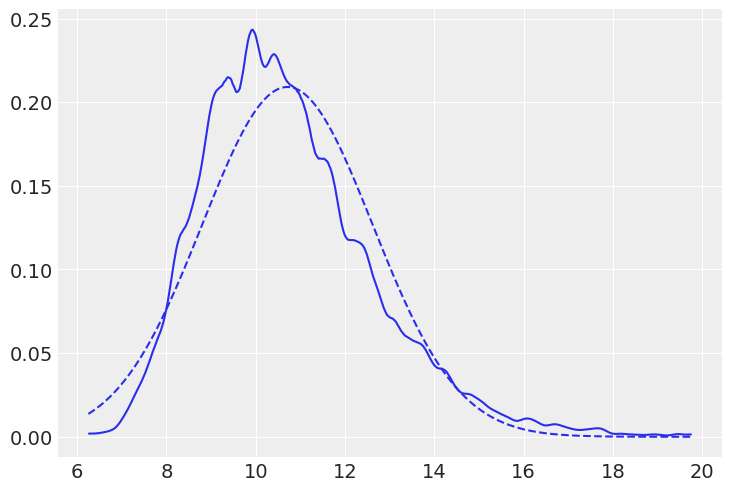

In [216]:
az.plot_kde(sample2_sigma)
x = jnp.sort(sample2_sigma)
plt.plot(x, jnp.exp(dist.Normal(jnp.mean(x), jnp.std(x)).log_prob(x)), "--")
plt.show()

### Code 4.26
Load and restrict the data to adults.

In [217]:
Howell1 = pd.read_csv("../data/Howell1.csv", sep=";")
d = Howell1
d2 = d[d["age"] >= 18]

### Code 4.27
Define a  list of formulas in the model.

In [218]:
def flist(height):
    mu = numpyro.sample("mu", dist.Normal(178, 20))
    sigma = numpyro.sample("sigma", dist.Uniform(0, 50))
    numpyro.sample("height", dist.Normal(mu, sigma), obs=height)

### Code 4.28
Run quadratic approximation on the model.

In [219]:
m4_1 = AutoLaplaceApproximation(flist)
svi = SVI(flist, m4_1, optim.Adam(1), Trace_ELBO(), height=d2.height.values)
svi_result = svi.run(random.PRNGKey(0), 2000)
p4_1 = svi_result.params

100%|██████████| 2000/2000 [00:00<00:00, 5454.78it/s, init loss: 4000.1150, avg. loss [1901-2000]: 1226.0389]


### Code 4.29
Look at posterior distribution.

In [220]:
samples = m4_1.sample_posterior(random.PRNGKey(1), p4_1, (1000,))
print_summary(samples, 0.89, False)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
        mu    154.60      0.40    154.60    154.00    155.28    995.05      1.00
     sigma      7.76      0.30      7.76      7.33      8.26   1007.15      1.00



### Code 4.30
Looking at start values for quadratic approximation.

In [221]:
start = {"mu": d2.height.mean(), "sigma": d2.height.std()}
m4_1 = AutoLaplaceApproximation(flist, init_loc_fn=init_to_value(values=start))
svi = SVI(flist, m4_1, optim.Adam(0.1), Trace_ELBO(), height=d2.height.values)
svi_result = svi.run(random.PRNGKey(0), 2000)
p4_1 = svi_result.params

100%|██████████| 2000/2000 [00:00<00:00, 5713.80it/s, init loss: 1226.0387, avg. loss [1901-2000]: 1226.0389]


### Code 4.31
Change the standard deviation of the prior to 0.1 (more narrow).

In [222]:
def model(height):
    mu = numpyro.sample("mu", dist.Normal(178, 0.1))
    sigma = numpyro.sample("sigma", dist.Uniform(0, 50))
    numpyro.sample("height", dist.Normal(mu, sigma), obs=height)


m4_2 = AutoLaplaceApproximation(model)
svi = SVI(model, m4_2, optim.Adam(1), Trace_ELBO(), height=d2.height.values)
svi_result = svi.run(random.PRNGKey(0), 2000)
p4_2 = svi_result.params
samples = m4_2.sample_posterior(random.PRNGKey(1), p4_2, (1000,))
print_summary(samples, 0.89, False)

100%|██████████| 2000/2000 [00:00<00:00, 5689.06it/s, init loss: 1584193.6250, avg. loss [1901-2000]: 1626.5830]



                mean       std    median      5.5%     94.5%     n_eff     r_hat
        mu    177.86      0.10    177.86    177.72    178.03    995.05      1.00
     sigma     24.57      0.94     24.60     23.01     25.96   1012.88      1.00



### Code 4.32
Matrix of variances and covarianceso.

In [223]:
samples = m4_1.sample_posterior(random.PRNGKey(1), p4_1, (1000,))
vcov = jnp.cov(jnp.stack(list(samples.values()), axis=0))
vcov

DeviceArray([[0.16249587, 0.00154646],
             [0.00154646, 0.08733496]], dtype=float32)

### Code 4.33
Decompose into a vector of variances for the parameters and a correlation matrix that tells us how changes in any parameter lead to correlated changes in the others.

In [224]:
print(jnp.diagonal(vcov))
print(vcov / jnp.sqrt(jnp.outer(jnp.diagonal(vcov), jnp.diagonal(vcov))))

[0.16249587 0.08733496]
[[1.         0.01298147]
 [0.01298147 1.        ]]


### Code 4.34
Get samples from the multi-dimensional posterior distribution.

In [225]:
post = m4_1.sample_posterior(random.PRNGKey(1), p4_1, (int(1e4),))
{latent: list(post[latent][:6]) for latent in post}

{'mu': [DeviceArray(154.2356, dtype=float32),
  DeviceArray(154.47672, dtype=float32),
  DeviceArray(154.97047, dtype=float32),
  DeviceArray(154.20374, dtype=float32),
  DeviceArray(155.48271, dtype=float32),
  DeviceArray(154.81831, dtype=float32)],
 'sigma': [DeviceArray(7.5602665, dtype=float32),
  DeviceArray(7.306454, dtype=float32),
  DeviceArray(7.27963, dtype=float32),
  DeviceArray(7.8118353, dtype=float32),
  DeviceArray(7.9042172, dtype=float32),
  DeviceArray(7.978001, dtype=float32)]}

### Code 4.35
Summarise the sample.

In [226]:
print_summary(post, 0.89, False)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
        mu    154.60      0.41    154.60    153.93    155.24   9926.99      1.00
     sigma      7.75      0.29      7.74      7.29      8.23   9502.45      1.00



### Code 4.36
Looking at how the multivariate normal simulation works.

In [227]:
samples_flat = jnp.stack(list(post.values()))
mu, sigma = jnp.mean(samples_flat, axis=1), jnp.cov(samples_flat)
post = dist.MultivariateNormal(mu, sigma).sample(random.PRNGKey(0), (int(1e4),))

### Code 4.37
Plot adult height vs adult weight.

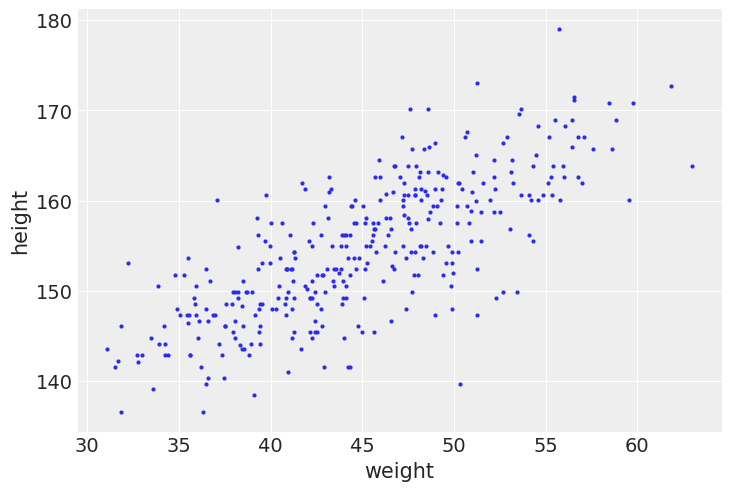

In [228]:
az.plot_pair(d2[["weight", "height"]].to_dict(orient="list"))
plt.show()

### Code 4.38
Simulate 100 pairs of alpha and beta values.

In [229]:
with numpyro.handlers.seed(rng_seed=2971):
    N = 100  # 100 lines
    a = numpyro.sample("a", dist.Normal(178, 20).expand([N]))
    b = numpyro.sample("b", dist.Normal(0, 10).expand([N]))

### Code 4.39
Plot all of the resulting lines.

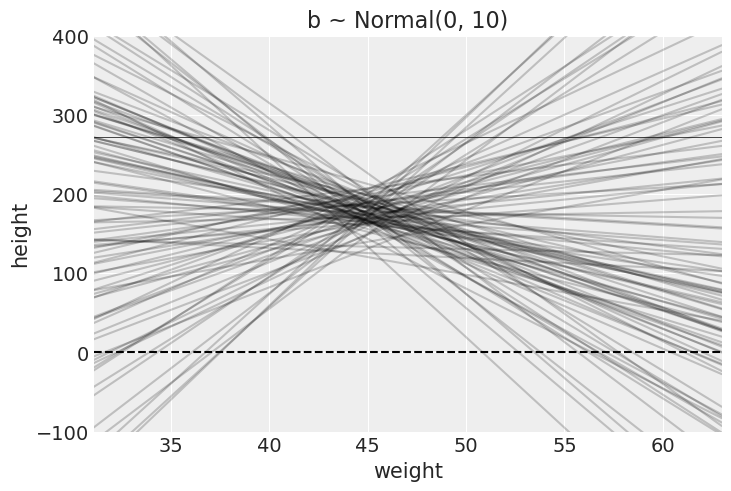

In [230]:
plt.subplot(
    xlim=(d2.weight.min(), d2.weight.max()),
    ylim=(-100, 400),
    xlabel="weight",
    ylabel="height",
)
plt.axhline(y=0, c="k", ls="--")
plt.axhline(y=272, c="k", ls="-", lw=0.5)
plt.title("b ~ Normal(0, 10)")
xbar = d2.weight.mean()
x = jnp.linspace(d2.weight.min(), d2.weight.max(), 101)
for i in range(N):
    plt.plot(x, a[i] + b[i] * (x - xbar), "k", alpha=0.2)
plt.show()

### Code 4.40
Explore the lognormal distribution.

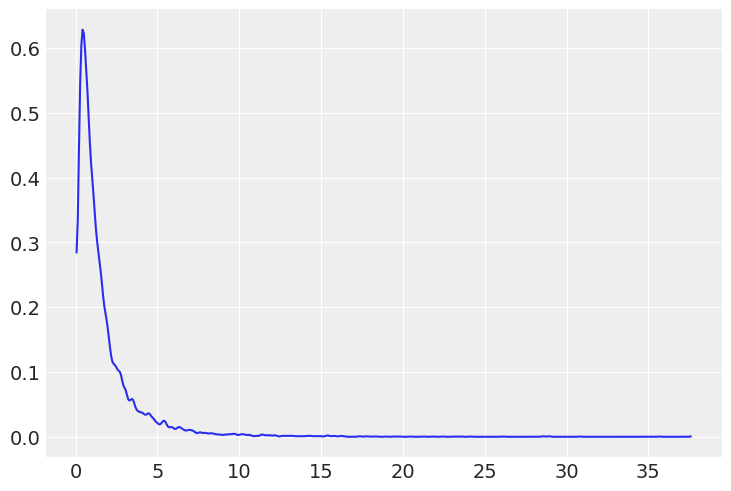

In [231]:
b = dist.LogNormal(0, 1).sample(random.PRNGKey(0), (int(1e4),))
az.plot_kde(b)
plt.show()

### Code 4.41
Redefine the model with a lognormal distribution for beta, and view the prior plotting results.

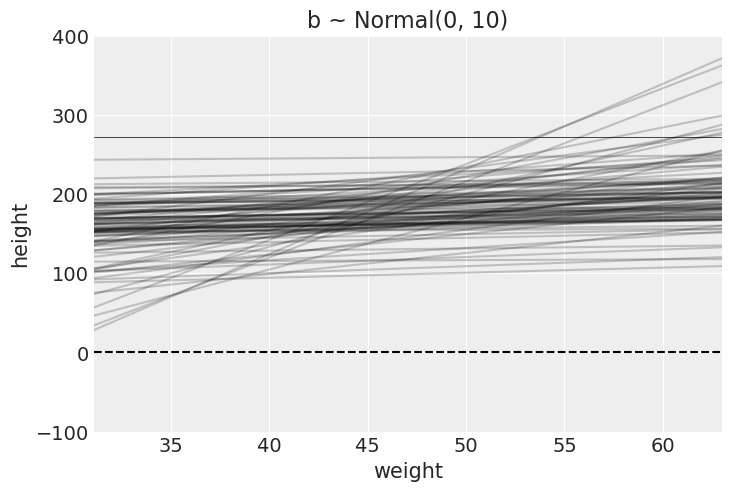

In [232]:
with numpyro.handlers.seed(rng_seed=2971):
    N = 100  # 100 lines
    a = numpyro.sample("a", dist.Normal(178, 28).expand([N]))
    b = numpyro.sample("b", dist.LogNormal(0, 1).expand([N]))
    
plt.subplot(
    xlim=(d2.weight.min(), d2.weight.max()),
    ylim=(-100, 400),
    xlabel="weight",
    ylabel="height",
)
plt.axhline(y=0, c="k", ls="--")
plt.axhline(y=272, c="k", ls="-", lw=0.5)
plt.title("b ~ Normal(0, 10)")
xbar = d2.weight.mean()
x = jnp.linspace(d2.weight.min(), d2.weight.max(), 101)
for i in range(N):
    plt.plot(x, a[i] + b[i] * (x - xbar), "k", alpha=0.2)
plt.show()

### Code 4.42
Build the posterior approximation.

In [233]:
# load data again, since it's a long way back
Howell1 = pd.read_csv("../data/Howell1.csv", sep=";")
d = Howell1
d2 = d[d["age"] >= 18]

# define the average weight, x-bar
xbar = d2.weight.mean()

# fit model
def model(weight, height):
    a = numpyro.sample("a", dist.Normal(178, 20))
    b = numpyro.sample("b", dist.LogNormal(0, 1))
    sigma = numpyro.sample("sigma", dist.Uniform(0, 50))
    mu = numpyro.deterministic("mu", a + b * (weight - xbar))
    numpyro.sample("height", dist.Normal(mu, sigma), obs=height)


m4_3 = AutoLaplaceApproximation(model)
svi = SVI(
    model,
    m4_3,
    optim.Adam(1),
    Trace_ELBO(),
    weight=d2.weight.values,
    height=d2.height.values,
)
svi_result = svi.run(random.PRNGKey(0), 2000)
p4_3 = svi_result.params

100%|██████████| 2000/2000 [00:00<00:00, 5226.46it/s, init loss: 40631.5430, avg. loss [1901-2000]: 1078.9296]


### Code 4.43
Alternate ways of working with log normal distributions.

In [234]:
def model(weight, height=None):
    a = numpyro.sample("a", dist.Normal(178, 20))
    log_b = numpyro.sample("log_b", dist.Normal(0, 1))
    sigma = numpyro.sample("sigma", dist.Uniform(0, 50))
    mu = numpyro.deterministic("mu", a + jnp.exp(log_b) * (weight - xbar))
    numpyro.sample("height", dist.Normal(mu, sigma), obs=height)


m4_3b = AutoLaplaceApproximation(model)
svi = SVI(
    model,
    m4_3b,
    optim.Adam(1),
    Trace_ELBO(),
    weight=d2.weight.values,
    height=d2.height.values,
)
svi_result = svi.run(random.PRNGKey(0), 2000)
p4_3b = svi_result.params

100%|██████████| 2000/2000 [00:00<00:00, 4916.54it/s, init loss: 40631.5430, avg. loss [1901-2000]: 1078.9297]


### Code 4.44
Inspect the marginal posteriors.

In [235]:
samples = m4_3.sample_posterior(random.PRNGKey(1), p4_3, (1000,))
samples.pop("mu")
print_summary(samples, 0.89, False)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
         a    154.62      0.27    154.63    154.16    155.03    931.50      1.00
         b      0.91      0.04      0.90      0.84      0.97   1083.74      1.00
     sigma      5.08      0.19      5.08      4.79      5.41    949.65      1.00



### Code 4.45
LLook at the covariance matrix.

In [236]:
vcov = jnp.cov(jnp.stack(list(samples.values()), axis=0))
jnp.round(vcov, 3)

DeviceArray([[ 0.075, -0.   ,  0.001],
             [-0.   ,  0.002, -0.   ],
             [ 0.001, -0.   ,  0.038]], dtype=float32)

### Code 4.46
Plot the raw data against the MAP estimates.

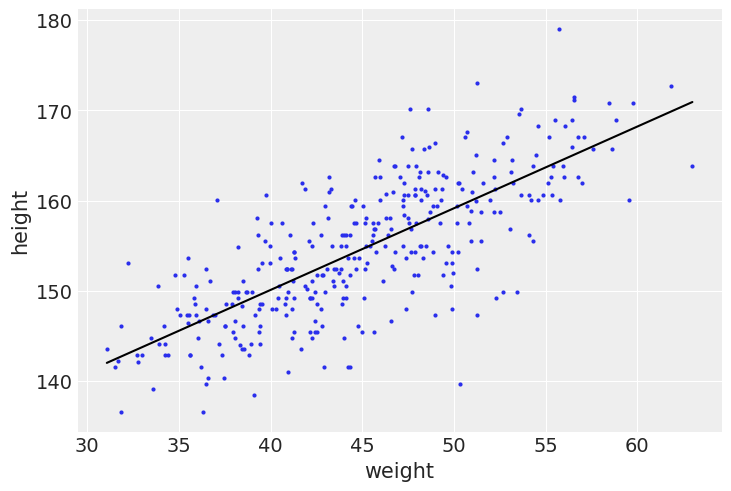

In [237]:
az.plot_pair(d2[["weight", "height"]].to_dict(orient="list"))
post = m4_3.sample_posterior(random.PRNGKey(1), p4_3, (1000,))
a_map = jnp.mean(post["a"])
b_map = jnp.mean(post["b"])
x = jnp.linspace(d2.weight.min(), d2.weight.max(), 101)
plt.plot(x, a_map + b_map * (x - xbar), "k")
plt.show()

### Code 4.47
Look at samples from the posterior distribution.

In [238]:
post = m4_3.sample_posterior(random.PRNGKey(1), p4_3, (1000,))
{latent: list(post[latent].reshape(-1)[:5]) for latent in post}

{'a': [DeviceArray(154.36615, dtype=float32),
  DeviceArray(154.78511, dtype=float32),
  DeviceArray(154.73534, dtype=float32),
  DeviceArray(154.53842, dtype=float32),
  DeviceArray(154.53549, dtype=float32)],
 'b': [DeviceArray(0.97464514, dtype=float32),
  DeviceArray(0.890005, dtype=float32),
  DeviceArray(0.81902224, dtype=float32),
  DeviceArray(0.8334105, dtype=float32),
  DeviceArray(1.0119181, dtype=float32)],
 'mu': [DeviceArray(157.12938, dtype=float32),
  DeviceArray(146.0771, dtype=float32),
  DeviceArray(141.5733, dtype=float32),
  DeviceArray(162.21344, dtype=float32),
  DeviceArray(150.74669, dtype=float32)],
 'sigma': [DeviceArray(4.976459, dtype=float32),
  DeviceArray(4.943529, dtype=float32),
  DeviceArray(5.2826023, dtype=float32),
  DeviceArray(4.877721, dtype=float32),
  DeviceArray(4.894869, dtype=float32)]}

### Code 4.48
Randomly select only 10 datapoints and re-estimate the model.

In [239]:
N = 10
dN = d2[:N]


def model(weight, height):
    a = numpyro.sample("a", dist.Normal(178, 20))
    b = numpyro.sample("b", dist.LogNormal(0, 1))
    sigma = numpyro.sample("sigma", dist.Uniform(0, 50))
    mu = a + b * (weight - jnp.mean(weight))
    numpyro.sample("height", dist.Normal(mu, sigma), obs=height)


mN = AutoLaplaceApproximation(model)
svi = SVI(
    model,
    mN,
    optim.Adam(1),
    Trace_ELBO(),
    weight=dN.weight.values,
    height=dN.height.values,
)
svi_result = svi.run(random.PRNGKey(0), 1000)
pN = svi_result.params

100%|██████████| 1000/1000 [00:00<00:00, 3677.82it/s, init loss: 1233.4980, avg. loss [951-1000]: 37.0481]


### Code 4.49
Plot a bunch of the posterior lines.

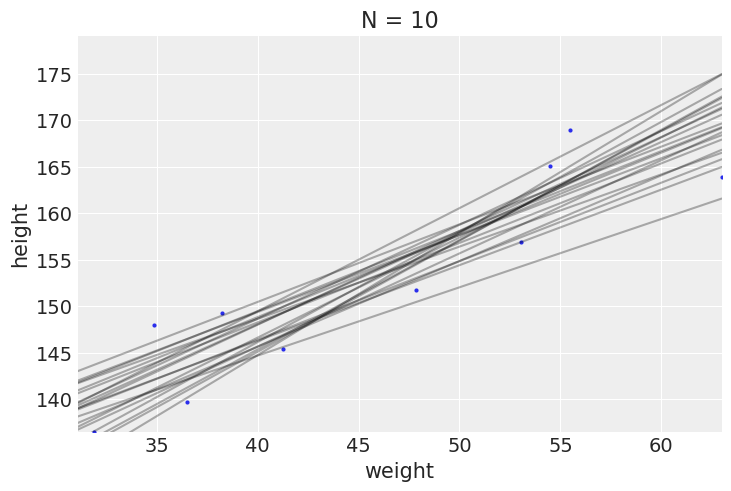

In [240]:
# extract 20 samples from the posterior
post = mN.sample_posterior(random.PRNGKey(1), pN, (20,))

# display raw data and sample size
ax = az.plot_pair(dN[["weight", "height"]].to_dict(orient="list"))
ax.set(
    xlim=(d2.weight.min(), d2.weight.max()),
    ylim=(d2.height.min(), d2.height.max()),
    title="N = {}".format(N),
)

# plot the lines, with transparency
x = jnp.linspace(d2.weight.min(), d2.weight.max(), 101)
for i in range(20):
    plt.plot(x, post["a"][i] + post["b"][i] * (x - dN.weight.mean()), "k", alpha=0.3)

### Code 4.50
Predictions for a specific weight.

In [241]:
post = m4_3.sample_posterior(random.PRNGKey(1), p4_3, (1000,))
mu_at_50 = post["a"] + post["b"] * (50 - xbar)

### Code 4.51
Plot the quadratic approximate posterior distribution of the mean height when the weight is 50.

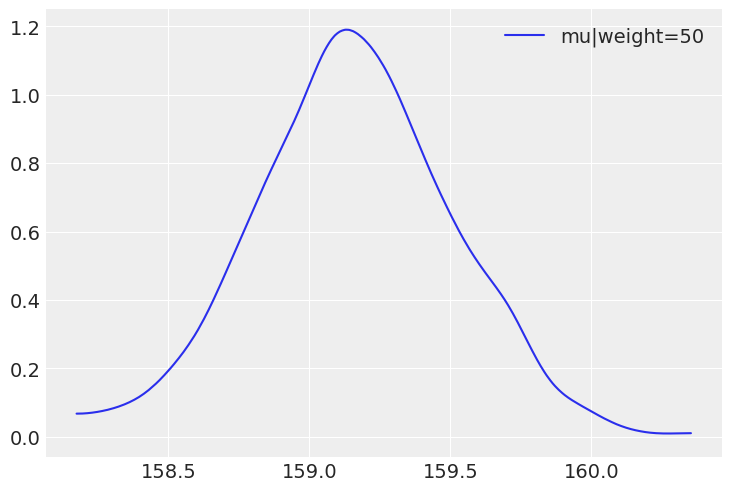

In [242]:
az.plot_kde(mu_at_50, label="mu|weight=50")
plt.show()

### Code 4.52
Find the 89% compatibility interval.

In [243]:
jnp.percentile(mu_at_50, q=jnp.array([5.5, 94.5]))

DeviceArray([158.5957 , 159.71445], dtype=float32)

### Code 4.53
Look at samples from the posterior distribution.

In [244]:
mu = Predictive(m4_3.model, post, return_sites=["mu"])(
    random.PRNGKey(2), d2.weight.values, d2.height.values
)["mu"]
mu.shape, list(mu[:5, 0])

((1000, 352),
 [DeviceArray(157.12938, dtype=float32),
  DeviceArray(157.30838, dtype=float32),
  DeviceArray(157.05736, dtype=float32),
  DeviceArray(156.90125, dtype=float32),
  DeviceArray(157.4044, dtype=float32)])

### Code 4.54
Compute the distribution of mu for each unique weight value on the horizontal axis.

In [245]:
# define sequence of weights to compute predictions for
# these values will be on the horizontal axis
weight_seq = jnp.arange(start=25, stop=71, step=1)

# use predictive to compute mu
# for each sample from posterior
# and for each weight in weight_seq
mu = Predictive(m4_3.model, post, return_sites=["mu"])(
    random.PRNGKey(2), weight_seq, None
)["mu"]
mu.shape, list(mu[:5, 0])

((1000, 46),
 [DeviceArray(134.88252, dtype=float32),
  DeviceArray(136.99348, dtype=float32),
  DeviceArray(138.36269, dtype=float32),
  DeviceArray(137.87814, dtype=float32),
  DeviceArray(134.30676, dtype=float32)])

### Code 4.55
Plot the distribution of mu values at each height.

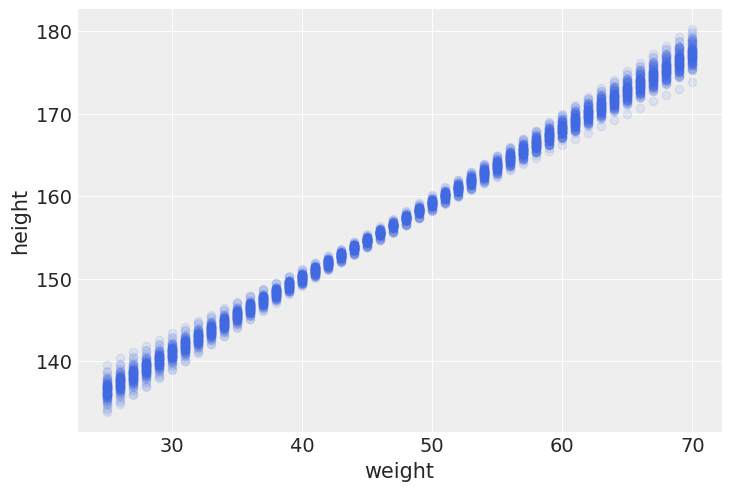

In [246]:
# use scatter_kwargs={"alpha": 0} to hide raw data
az.plot_pair(
    d2[["weight", "height"]].to_dict(orient="list"), scatter_kwargs={"alpha": 0}
)

# loop over samples and plot each mu value
for i in range(100):
    plt.plot(weight_seq, mu[i], "o", c="royalblue", alpha=0.1)

### Code 4.56

Summarize the distribution for each weight value.

In [247]:
# summarize the distribution of mu
mu_mean = jnp.mean(mu, 0)
mu_PI = jnp.percentile(mu, q=jnp.array([5.5, 94.5]), axis=0)

### Code 4.57
Plot summaries over the data.

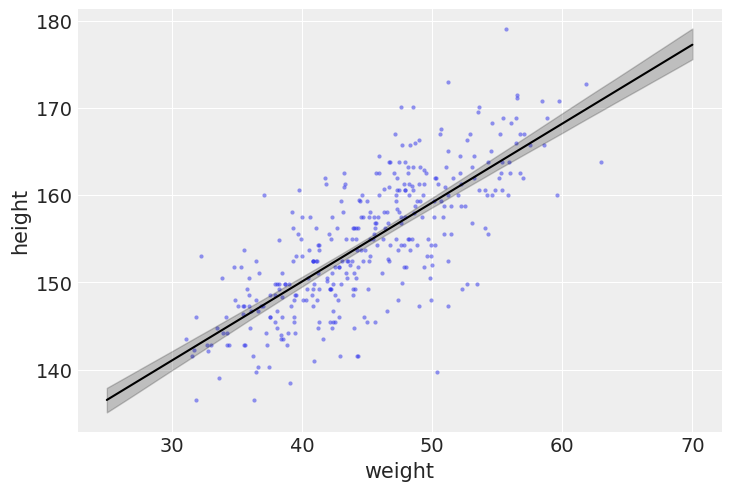

In [248]:
# plot raw data
# fading out points to make line and interval more visible
az.plot_pair(
    d2[["weight", "height"]].to_dict(orient="list"), scatter_kwargs={"alpha": 0.5}
)

# plot the MAP line, aka the mean mu for each weight
plt.plot(weight_seq, mu_mean, "k")

# plot a shaded region for 89% PI
plt.fill_between(weight_seq, mu_PI[0], mu_PI[1], color="k", alpha=0.2)
plt.show()

### Code 4.58
Diving into the "link" function.

In [249]:
post = m4_3.sample_posterior(random.PRNGKey(1), p4_3, (1000,))
mu_link = lambda weight: post["a"] + post["b"] * (weight - xbar)
weight_seq = jnp.arange(start=25, stop=71, step=1)
mu = vmap(mu_link)(weight_seq).T
mu_mean = jnp.mean(mu, 0)
mu_HPDI = hpdi(mu, prob=0.89, axis=0)

### Code 4.59
Making predictive simulations from the posterior distribution.

In [250]:
sim_height = Predictive(m4_3.model, post, return_sites=["height"])(
    random.PRNGKey(2), weight_seq, None
)["height"]
sim_height.shape, list(sim_height[:5, 0])

((1000, 46),
 [DeviceArray(135.85771, dtype=float32),
  DeviceArray(137.52162, dtype=float32),
  DeviceArray(133.89777, dtype=float32),
  DeviceArray(138.14607, dtype=float32),
  DeviceArray(131.1664, dtype=float32)])

### Code 4.60
Summarise the simulated heights with an 89% CI.

In [251]:
height_PI = jnp.percentile(sim_height, q=jnp.array([5.5, 94.5]), axis=0)

### Code 4.61
Plot the average line, the shaded region of 89% plausible mu, and the boundaries of the smulated heights the model expects

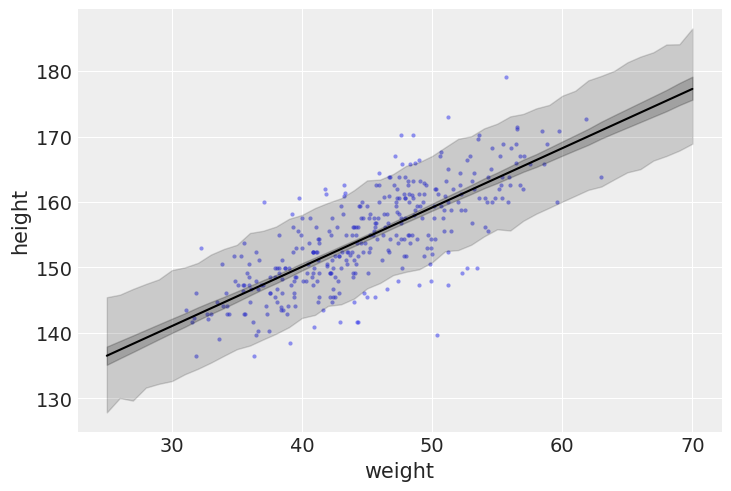

In [252]:
# plot raw data
az.plot_pair(
    d2[["weight", "height"]].to_dict(orient="list"), scatter_kwargs={"alpha": 0.5}
)

# draw MAP line
plt.plot(weight_seq, mu_mean, "k")

# draw HPDI region for line
plt.fill_between(weight_seq, mu_HPDI[0], mu_HPDI[1], color="k", alpha=0.2)

# draw PI region for simulated heights
plt.fill_between(weight_seq, height_PI[0], height_PI[1], color="k", alpha=0.15)
plt.show()

### Code 4.62
Can increase the number of samples to improve smoothness of interval.

In [253]:
post = m4_3.sample_posterior(random.PRNGKey(1), p4_3, sample_shape=(int(1e4),))
sim_height = Predictive(m4_3.model, post, return_sites=["height"])(
    random.PRNGKey(2), weight_seq, None
)["height"]
height_PI = jnp.percentile(sim_height, q=jnp.array([5.5, 94.5]), axis=0)

### Code 4.63
Diving into the simulation function.

In [254]:
post = m4_3.sample_posterior(random.PRNGKey(1), p4_3, (1000,))
weight_seq = jnp.arange(25, 71)
sim_height = vmap(
    lambda i, weight: dist.Normal(
        post["a"] + post["b"] * (weight - xbar), post["sigma"]
    ).sample(random.PRNGKey(i))
)(jnp.arange(len(weight_seq)), weight_seq).T
height_PI = jnp.percentile(sim_height, q=jnp.array([5.5, 94.5]), axis=0)

### Code 4.64

In [255]:
Howell1 = pd.read_csv("../data/Howell1.csv", sep=";")
d = Howell1
d.info()
d.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 544 entries, 0 to 543
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   height  544 non-null    float64
 1   weight  544 non-null    float64
 2   age     544 non-null    float64
 3   male    544 non-null    int64  
dtypes: float64(3), int64(1)
memory usage: 17.1 KB


,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


### Code 4.65

In [256]:
d["weight_s"] = (d.weight - d.weight.mean()) / d.weight.std()
d["weight_s2"] = d.weight_s ** 2


def model(weight_s, weight_s2, height=None):
    a = numpyro.sample("a", dist.Normal(178, 20))
    b1 = numpyro.sample("b1", dist.LogNormal(0, 1))
    b2 = numpyro.sample("b2", dist.Normal(0, 1))
    sigma = numpyro.sample("sigma", dist.Uniform(0, 50))
    mu = numpyro.deterministic("mu", a + b1 * weight_s + b2 * weight_s2)
    numpyro.sample("height", dist.Normal(mu, sigma), obs=height)


m4_5 = AutoLaplaceApproximation(model)
svi = SVI(
    model,
    m4_5,
    optim.Adam(0.3),
    Trace_ELBO(),
    weight_s=d.weight_s.values,
    weight_s2=d.weight_s2.values,
    height=d.height.values,
)
svi_result = svi.run(random.PRNGKey(0), 3000)
p4_5 = svi_result.params

100%|██████████| 3000/3000 [00:00<00:00, 5696.27it/s, init loss: 68267.6406, avg. loss [2851-3000]: 1770.2694]


### Code 4.66

In [257]:
samples = m4_5.sample_posterior(random.PRNGKey(1), p4_5, (1000,))
print_summary({k: v for k, v in samples.items() if k != "mu"}, 0.89, False)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
         a    146.05      0.36    146.03    145.47    146.58   1049.96      1.00
        b1     21.75      0.30     21.75     21.25     22.18    886.88      1.00
        b2     -7.79      0.28     -7.79     -8.21     -7.32   1083.62      1.00
     sigma      5.78      0.17      5.78      5.49      6.02    973.22      1.00



### Code 4.67

In [258]:
weight_seq = jnp.linspace(start=-2.2, stop=2, num=30)
pred_dat = {"weight_s": weight_seq, "weight_s2": weight_seq ** 2}
post = m4_5.sample_posterior(random.PRNGKey(1), p4_5, (1000,))
predictive = Predictive(m4_5.model, post)
mu = predictive(random.PRNGKey(2), **pred_dat)["mu"]
mu_mean = jnp.mean(mu, 0)
mu_PI = jnp.percentile(mu, q=jnp.array([5.5, 94.5]), axis=0)
sim_height = predictive(random.PRNGKey(3), **pred_dat)["height"]
height_PI = jnp.percentile(sim_height, q=jnp.array([5.5, 94.5]), axis=0)

### Code 4.68

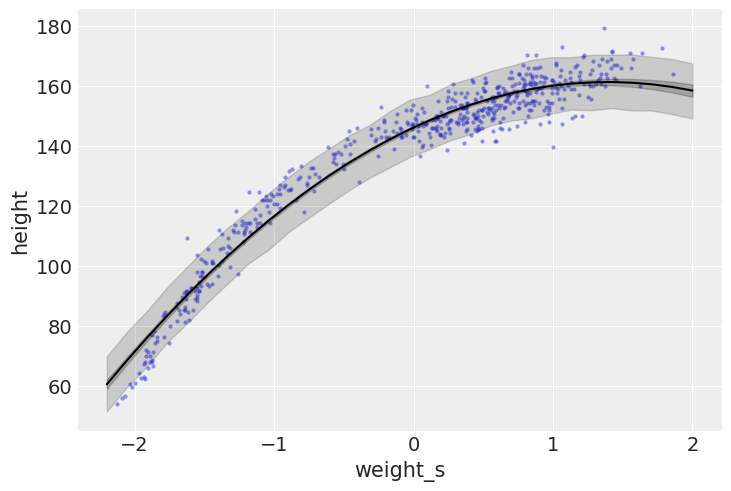

In [259]:
az.plot_pair(
    d[["weight_s", "height"]].to_dict(orient="list"), scatter_kwargs={"alpha": 0.5}
)
plt.plot(weight_seq, mu_mean, "k")
plt.fill_between(weight_seq, mu_PI[0], mu_PI[1], color="k", alpha=0.2)
plt.fill_between(weight_seq, height_PI[0], height_PI[1], color="k", alpha=0.15)
plt.show()

### Code 4.69

In [260]:
d["weight_s3"] = d.weight_s ** 3


def model(weight_s, weight_s2, weight_s3, height):
    a = numpyro.sample("a", dist.Normal(178, 20))
    b1 = numpyro.sample("b1", dist.LogNormal(0, 1))
    b2 = numpyro.sample("b2", dist.Normal(0, 1))
    b3 = numpyro.sample("b3", dist.Normal(0, 1))
    sigma = numpyro.sample("sigma", dist.Uniform(0, 50))
    mu = a + b1 * weight_s + b2 * weight_s2 + b3 * weight_s3
    numpyro.sample("height", dist.Normal(mu, sigma), obs=height)


m4_6 = AutoLaplaceApproximation(model)
svi = SVI(
    model,
    m4_6,
    optim.Adam(0.3),
    Trace_ELBO(),
    weight_s=d.weight_s.values,
    weight_s2=d.weight_s2.values,
    weight_s3=d.weight_s3.values,
    height=d.height.values,
)
svi_result = svi.run(random.PRNGKey(0), 1000)
p4_6 = svi_result.params

100%|██████████| 1000/1000 [00:00<00:00, 3196.63it/s, init loss: 5544.0449, avg. loss [951-1000]: 1668.3280]


### Code 4.70

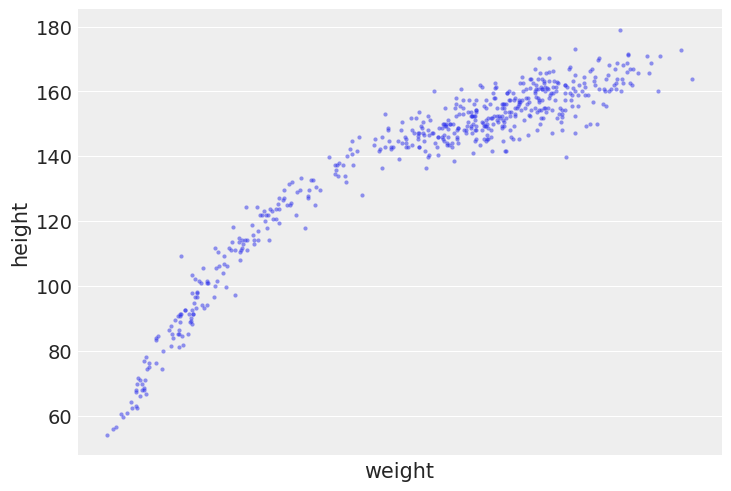

In [261]:
ax = az.plot_pair(
    d[["weight_s", "height"]].to_dict(orient="list"), scatter_kwargs={"alpha": 0.5}
)
ax.set(xlabel="weight", ylabel="height", xticks=[])
fig = plt.gcf()

### Code 4.71

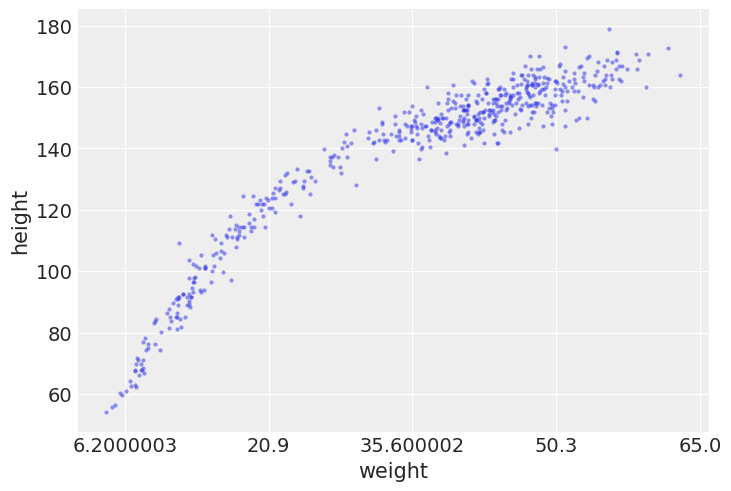

In [262]:
at = jnp.array([-2, -1, 0, 1, 2])
labels = at * d.weight.std() + d.weight.mean()
ax.set_xticks(at)
ax.set_xticklabels([round(label, 1) for label in labels])
fig

### Code 4.72

In [263]:
cherry_blossoms = pd.read_csv("../data/cherry_blossoms.csv", sep=";")
d = cherry_blossoms
print_summary({"year": d.year.dropna().values}, 0.89, False)
print_summary({"doy": d.doy.dropna().values}, 0.89, False)
print_summary({"temp": d.temp.dropna().values}, 0.89, False)
print_summary({"temp_upper": d.temp_upper.dropna().values}, 0.89, False)
print_summary({"temp_lower": d.temp_lower.dropna().values}, 0.89, False)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
      year   1408.00    350.88   1408.00    801.00   1882.00      2.51      2.65


                mean       std    median      5.5%     94.5%     n_eff     r_hat
       doy    104.54      6.41    105.00     93.00    113.00    111.98      1.00


                mean       std    median      5.5%     94.5%     n_eff     r_hat
      temp      6.14      0.66      6.10      5.03      7.13     22.07      1.02


                  mean       std    median      5.5%     94.5%     n_eff     r_hat
  temp_upper      7.19      0.99      7.04      5.66      8.54     10.11      1.24


                  mean       std    median      5.5%     94.5%     n_eff     r_hat
  temp_lower      5.10      0.85      5.14      3.79      6.37     21.90      1.11



### Code 4.73

In [264]:
d2 = d[d.doy.notna()]  # complete cases on doy
num_knots = 15
knot_list = jnp.quantile(
    d2.year.values.astype(float), q=jnp.linspace(0, 1, num=num_knots)
)

### Code 4.74

In [265]:
knots = jnp.pad(knot_list, (3, 3), mode="edge")
B = BSpline(knots, jnp.identity(num_knots + 2), k=3)(d2.year.values)

### Code 4.75

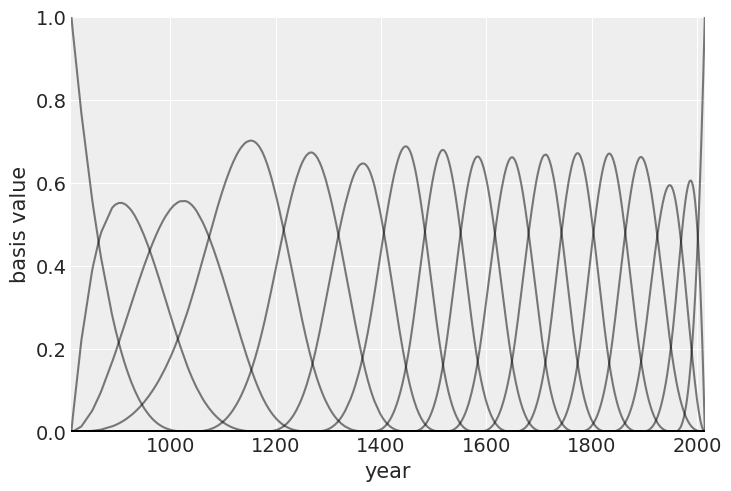

In [266]:
plt.subplot(
    xlim=(d2.year.min(), d2.year.max()),
    ylim=(0, 1),
    xlabel="year",
    ylabel="basis value",
)
for i in range(B.shape[1]):
    plt.plot(d2.year, B[:, i], "k", alpha=0.5)

### Code 4.76

In [267]:
def model(B, D):
    a = numpyro.sample("a", dist.Normal(100, 10))
    w = numpyro.sample("w", dist.Normal(0, 10).expand(B.shape[1:]))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = numpyro.deterministic("mu", a + B @ w)
    numpyro.sample("D", dist.Normal(mu, sigma), obs=D)


start = {"w": jnp.zeros(B.shape[1])}
m4_7 = AutoLaplaceApproximation(model, init_loc_fn=init_to_value(values=start))
svi = SVI(model, m4_7, optim.Adam(1), Trace_ELBO(), B=B, D=d2.doy.values)
svi_result = svi.run(random.PRNGKey(0), 20000)
p4_7 = svi_result.params

100%|██████████| 20000/20000 [00:02<00:00, 8273.69it/s, init loss: 2476234.7500, avg. loss [19001-20000]: 2705.3564]


### Code 4.77

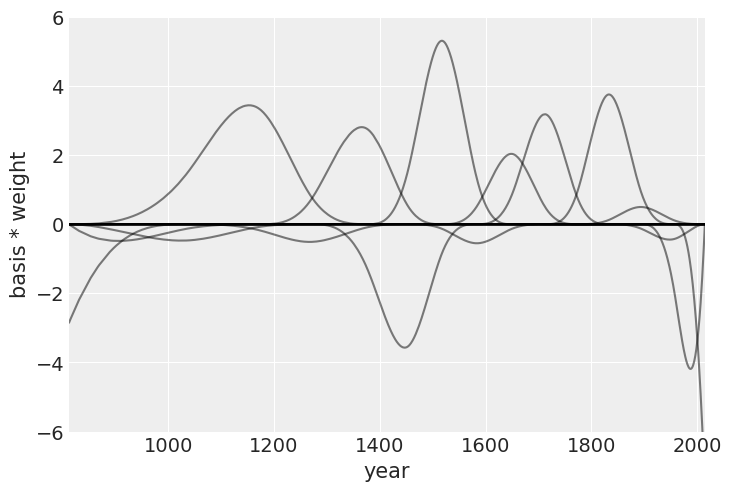

In [268]:
post = m4_7.sample_posterior(random.PRNGKey(1), p4_7, (1000,))
w = jnp.mean(post["w"], 0)
plt.subplot(
    xlim=(d2.year.min(), d2.year.max()),
    ylim=(-6, 6),
    xlabel="year",
    ylabel="basis * weight",
)
for i in range(B.shape[1]):
    plt.plot(d2.year, (w[i] * B[:, i]), "k", alpha=0.5)

### Code 4.78

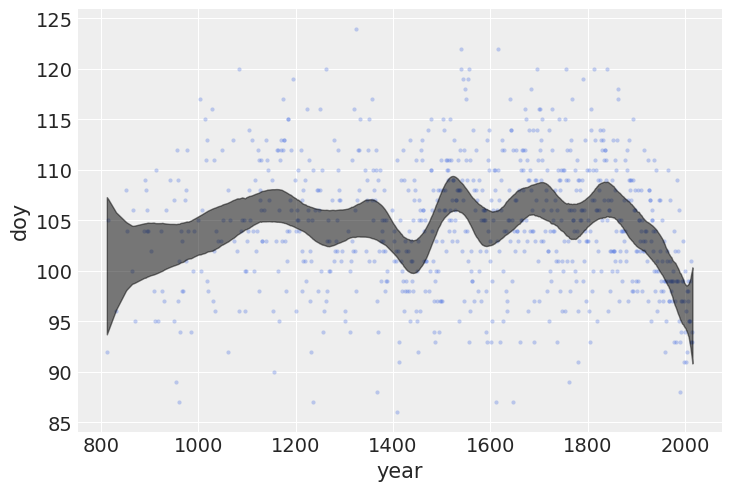

In [269]:
mu = post["mu"]
mu_PI = jnp.percentile(mu, q=jnp.array([1.5, 98.5]), axis=0)
az.plot_pair(
    d2[["year", "doy"]].astype(float).to_dict(orient="list"),
    scatter_kwargs={"c": "royalblue", "alpha": 0.3,
                    #"markersize": 10
                    },
)
plt.fill_between(d2.year, mu_PI[0], mu_PI[1], color="k", alpha=0.5)
plt.show()

### Code 4.79

In [270]:
def model(B, D):
    a = numpyro.sample("a", dist.Normal(100, 10))
    w = numpyro.sample("w", dist.Normal(0, 10).expand(B.shape[1:]))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = numpyro.deterministic("mu", a + jnp.sum(B * w, axis=-1))
    numpyro.sample("D", dist.Normal(mu, sigma), obs=D)


start = {"w": jnp.zeros(B.shape[1])}
m4_7alt = AutoLaplaceApproximation(model, init_loc_fn=init_to_value(values=start))
svi = SVI(model, m4_7alt, optim.Adam(1), Trace_ELBO(), B=B, D=d2.doy.values)
svi_result = svi.run(random.PRNGKey(0), 20000)
p4_7alt = svi_result.params

100%|██████████| 20000/20000 [00:02<00:00, 7393.21it/s, init loss: 2476234.7500, avg. loss [19001-20000]: 2705.3179]
